In [1]:
%matplotlib inline
import numpy as np
import json
import math
from random import gauss
import matplotlib.pyplot as pyplot
from matplotlib.finance import candlestick_ohlc
from datetime import date

In [2]:
def bs_model(S, T, v, mu=0, sigma=1, r=0.02):
    return S * math.exp((r - 0.5 * v**2) * T + v * (T ** 0.5) * gauss(mu, sigma))

In [13]:
with open('./txf_date') as f:
    data_rel = json.load(f)

In [592]:
def extract_close(data):
    return np.array(data)[:, -2].astype(float)


def extract_ohcl(data):
    return np.array(data)[:, 2:-1].astype(float)


# cal volatility
def volatility(data: 'Single Date', time: 'seconds'=60):
    '''
    >>> volatility(data[-1])
    
    1/4 day
    '''
    # d = np.array(data)[:, -1].astype(float)
    d = data
    return (((d[1:] - d[:-1]) / d[:-1]).std()) / math.sqrt(time / (252 * 5 * 3600))


def gen_k(data, start_price):
    close = extract_close(data)
    S = start_price
    T = 60 / (252 * 5 * 3600)  # 1 min
    v = volatility(data)

    ret = np.empty((len(data),))
    for i in range(len(data)):
        S = bs_model(S=S, T=T, v=v, r=0.02)
        ret[i] = round(S)
    return ret

def merge_price(d):
    o = d[0]
    c = d[-1]
    h = d.max()
    l = d.min()
    return np.array([o, h, l, c])

In [5]:
def gen_graph(n):
    sim_k = gen_k(data_rel, data_rel[0][0])
    sim_k = np.array([merge_price(i) for i in sim_k.reshape((sim_k.size // 4, 4))])

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 8)
    candlestick_ohlc(ax,
                     np.hstack((np.arange(sim_k.shape[0]).reshape((sim_k.shape[0], 1)), sim_k)), 
                     width=0.8,
                     colorup='r',
                     colordown='green')
    
    filename = 'sim/{}'.format(n)
    fig.savefig(filename)
    sim_k.tofile('{}.raw'.format(filename))

In [52]:
rel = data_rel[-318:-70]

In [70]:
rel_close = np.array([i[-1][-2] for i in rel])

In [161]:
def sim_day():
    day_vol = volatility(rel_close, 5 * 3600)

    S = rel_close[0]
    T = 1 / 252  # 1 day

    mean_col = (np.array(rel_close).mean() - rel_close[0])/252
    sim_close = np.empty((len(rel_close),))
    for i in range(len(rel_close)):
        S = bs_model(S=S, T=T, v=day_vol, r=0.02) + mean_col
        sim_close[i] = round(S)
    return sim_close

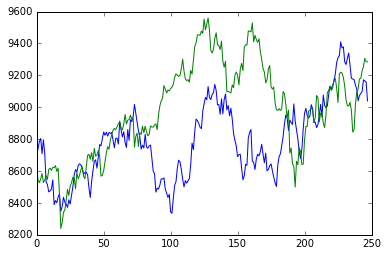

In [185]:
sim_close = sim_day()
plt.plot(sim_close)
plt.plot(rel_close)

In [940]:
def sim_intraday(rel_data, close_p):
    def extract_close(data):
        return np.array(data)[:, -2].astype(float)

    close = extract_close(rel_data)
    v = volatility(close)

    S = rel_data[0][2]
    T = 60 / (252 * 5 * 3600)
    mean = (np.array(close).mean() - close[0]) / len(close)
    sim_close = np.empty((len(close),))
    for i in range(len(close)):
        S = bs_model(S=S, T=T, v=v, r=0.02) + mean
        sim_close[i] = round(S)

    sim_close += close_p - sim_close[-1]

    return sim_close

([<matplotlib.lines.Line2D at 0x85629e208>,
  <matplotlib.patches.Rectangle at 0x857063780>])

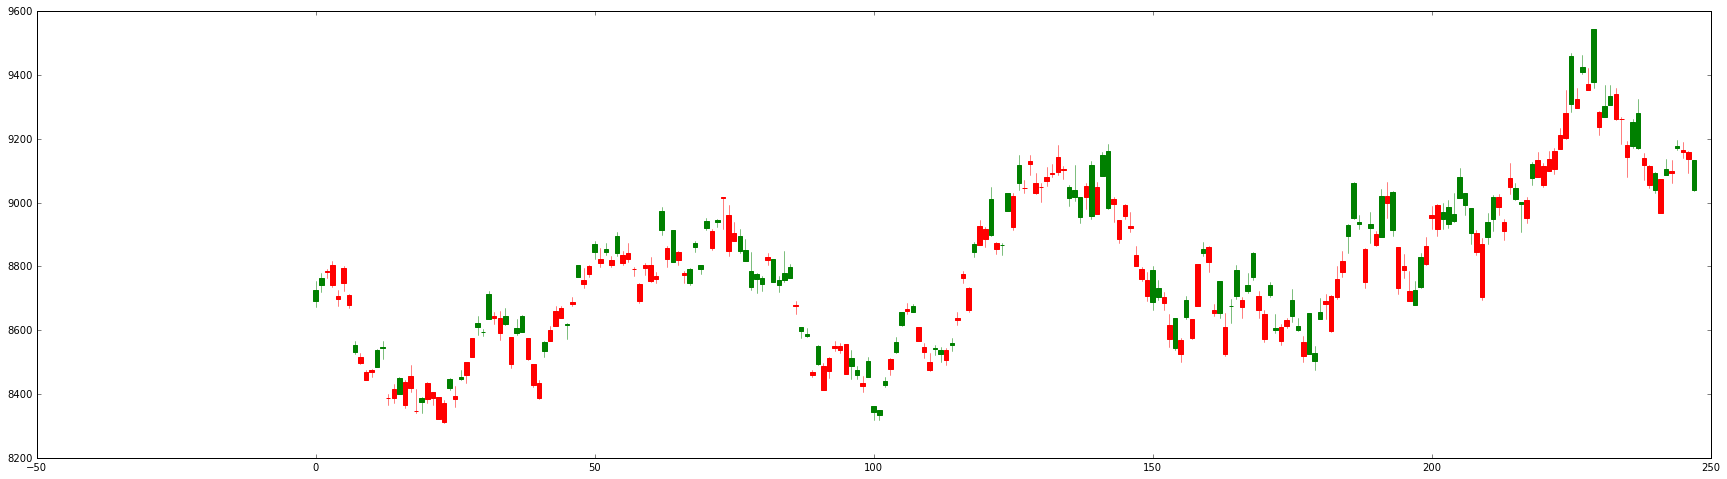

In [943]:
t = np.array([merge_price(sim_intraday(d, sim_close[i])) for i, d in enumerate(rel)])

fig, ax = plt.subplots()
fig.set_size_inches(30, 8)
candlestick_ohlc(ax,
                 np.hstack((np.arange(t.shape[0]).reshape((t.shape[0], 1)), t)), 
                 width=0.8,
                 colorup='r',
                 colordown='green')

In [953]:
t2 = np.array([merge_price(np.array(i)[:, 2:-1].astype(float).flatten()) for i in rel])

def candle_plot(t):
    fig, ax = plt.subplots()
    fig.set_size_inches(30, 8)
    candlestick_ohlc(ax,
                     np.hstack((np.arange(t.shape[0]).reshape((t.shape[0], 1)), t)), 
                     width=0.8,
                     colorup='r',
                     colordown='green')

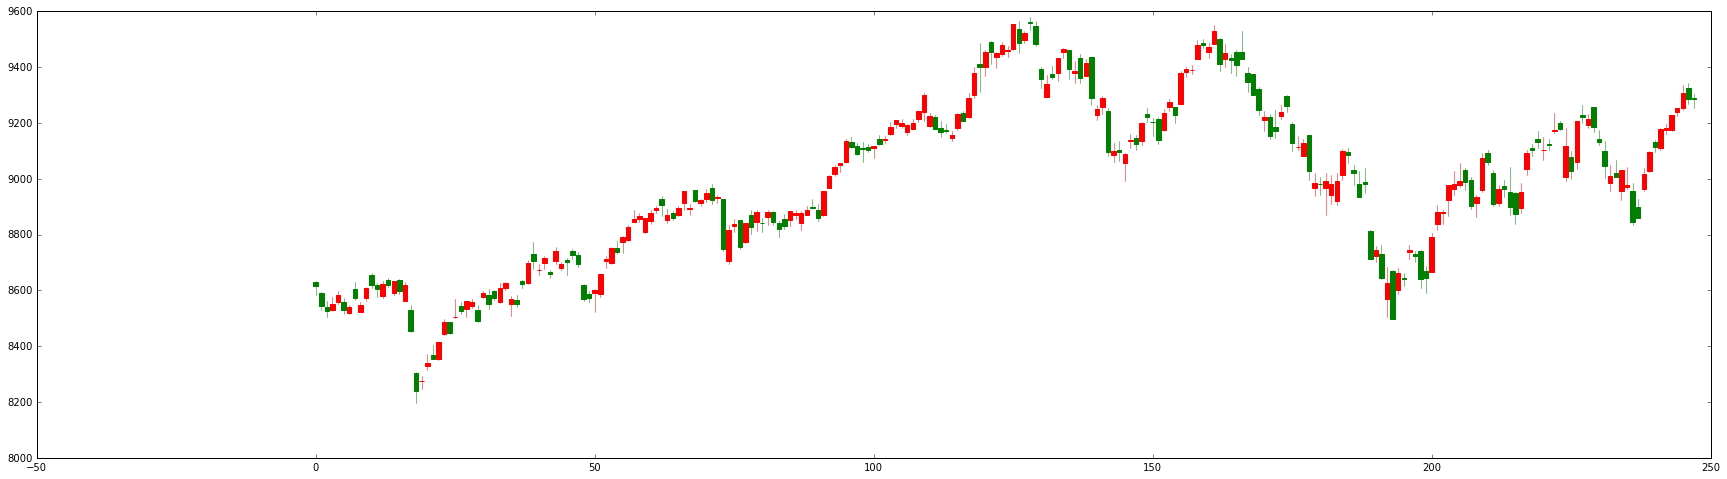

In [954]:
candle_plot(t2)